In [1]:
# Supermart Grocery Sales 
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Tuple

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
# 2. DATA LOADING & VALIDATION

df = pd.read_csv(
    r"C:\Users\GNANASEKARAN\OneDrive\Documents\Python Project\Supermart Grocery Sales - Retail Analytics Dataset.csv"
)

required_columns = [
    "Order ID", "Customer Name", "Category", "Sub Category",
    "City", "Order Date", "Region", "Sales", "Discount",
    "Profit", "State"
]

missing_cols = [c for c in required_columns if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

df.drop_duplicates(inplace=True)

print("Dataset loaded successfully")
print("Shape:", df.shape)
df.head()


Dataset loaded successfully
Shape: (9994, 11)


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [3]:
# SECTION 3: PREPROCESSING & FEATURE ENGINEERING

df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d-%m-%Y", errors="coerce")

df["Order_Year"] = df["Order Date"].dt.year
df["Order_Month"] = df["Order Date"].dt.month
df["Order_Day"] = df["Order Date"].dt.day
df["Order_DayOfWeek"] = df["Order Date"].dt.dayofweek

df["Order_WeekOfYear"] = df["Order Date"].dt.isocalendar().week.astype("Int64")

df["Is_Weekend"] = df["Order_DayOfWeek"].isin([5, 6]).astype(int)
df["Is_QuarterEnd"] = df["Order Date"].dt.is_quarter_end.astype(int)

# Frequency Encoding (safe)
df["Category_Frequency"] = df.groupby("Category")["Order ID"].transform("count")
df["City_Frequency"] = df.groupby("City")["Order ID"].transform("count")

df.head()


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,Order_Year,Order_Month,Order_Day,Order_DayOfWeek,Order_WeekOfYear,Is_Weekend,Is_QuarterEnd,Category_Frequency,City_Frequency
0,OD1,Harish,Oil & Masala,Masalas,Vellore,2017-08-11,North,1254,0.12,401.28,Tamil Nadu,2017.0,8.0,11.0,4.0,32,0,0,1361,435
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,2017-08-11,South,749,0.18,149.80,Tamil Nadu,2017.0,8.0,11.0,4.0,32,0,0,1400,440
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,2017-12-06,West,2360,0.21,165.20,Tamil Nadu,2017.0,12.0,6.0,2.0,49,0,0,1398,434
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,2016-11-10,South,896,0.25,89.60,Tamil Nadu,2016.0,11.0,10.0,3.0,45,0,0,1418,376
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,2016-11-10,South,2355,0.26,918.45,Tamil Nadu,2016.0,11.0,10.0,3.0,45,0,0,1398,404


In [4]:
df = df.dropna(subset=["Order Date"])
df = df.reset_index(drop=True)

print("Remaining missing values:\n")
print(df.isna().sum())


Remaining missing values:

Order ID              0
Customer Name         0
Category              0
Sub Category          0
City                  0
Order Date            0
Region                0
Sales                 0
Discount              0
Profit                0
State                 0
Order_Year            0
Order_Month           0
Order_Day             0
Order_DayOfWeek       0
Order_WeekOfYear      0
Is_Weekend            0
Is_QuarterEnd         0
Category_Frequency    0
City_Frequency        0
dtype: int64


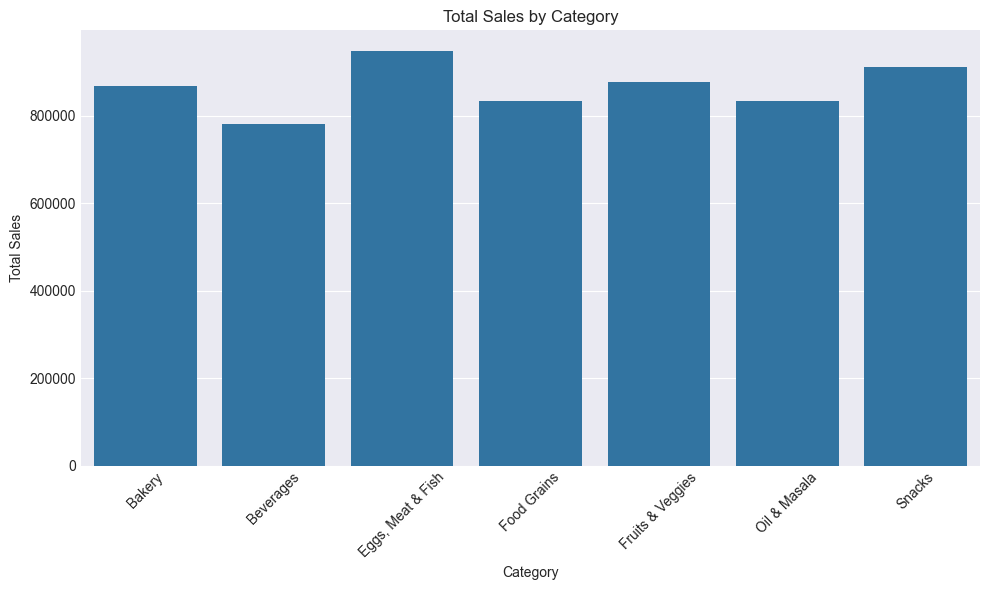

In [5]:
# SECTION 4: EXPLORATORY DATA ANALYSIS (EDA)

df_eda = df.copy()

# Profit Margin (EDA only – NOT used for ML)
df_eda["Profit_Margin"] = (df_eda["Profit"] / (df_eda["Sales"] + 1e-6)) * 100

plt.figure(figsize=(10, 6))
sns.barplot(
    x=df_eda.groupby("Category")["Sales"].sum().index,
    y=df_eda.groupby("Category")["Sales"].sum().values
)
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

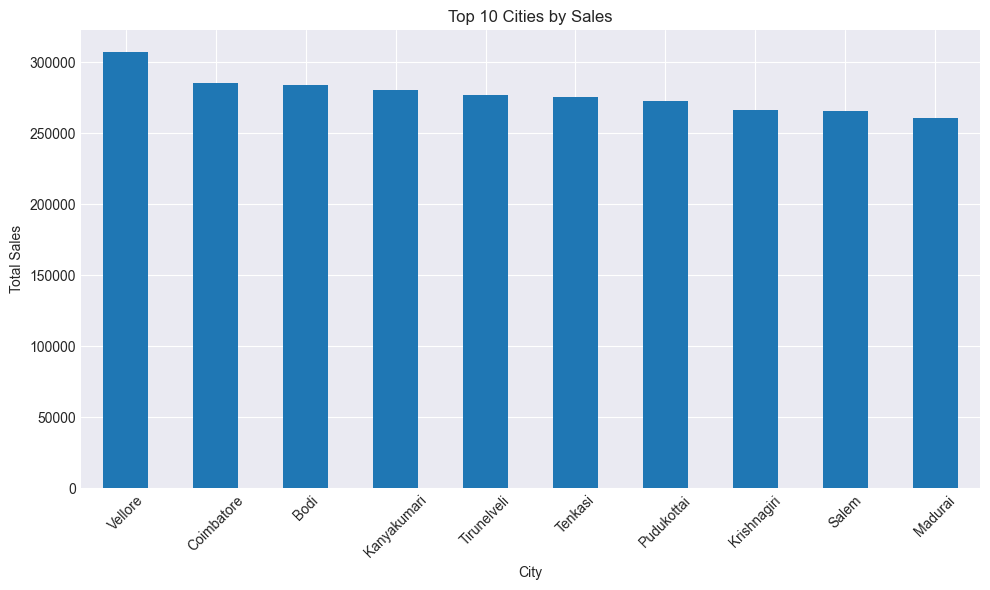

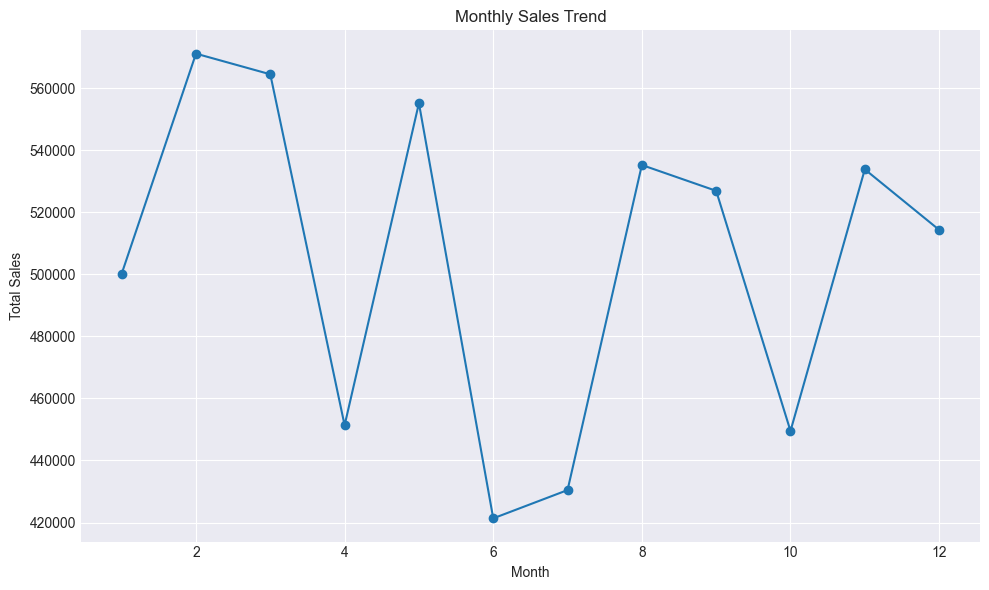

In [6]:
# Sales by City (Top 10)
plt.figure(figsize=(10, 6))
df_eda.groupby("City")["Sales"].sum().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Cities by Sales")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly Sales Trend
plt.figure(figsize=(10, 6))
df_eda.groupby("Order_Month")["Sales"].sum().plot(marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

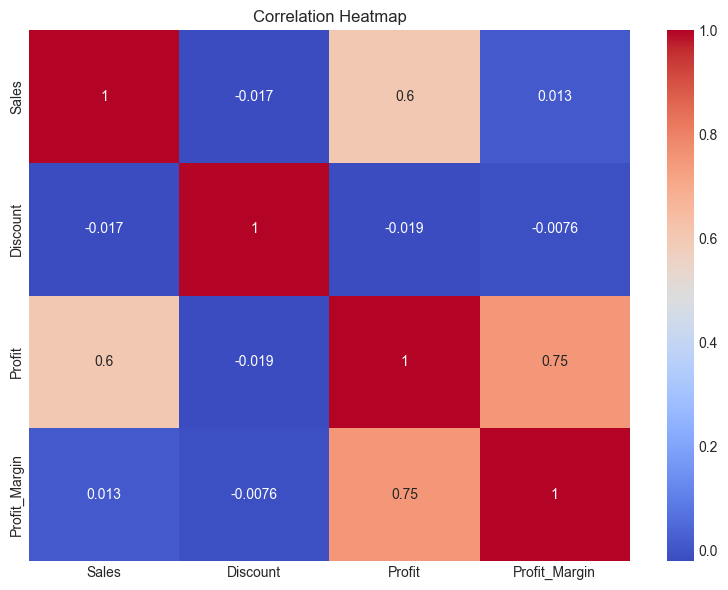

In [7]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_eda[["Sales", "Discount", "Profit", "Profit_Margin"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [8]:
# SECTION 5: MACHINE LEARNING SETUP

print("Preparing data for Machine Learning...")

# Sort by date (VERY IMPORTANT for time series)
df = df.sort_values("Order Date")

TARGET = "Profit"

features = [
    "Sales", "Discount",
    "Order_Month", "Order_DayOfWeek",
    "Is_Weekend", "Is_QuarterEnd",
    "Category", "Sub Category", "Region", "State"
]

X = df[features]
y = df[TARGET]

numeric_features = [
    "Sales", "Discount", "Order_Month",
    "Order_DayOfWeek", "Is_Weekend", "Is_QuarterEnd"
]

categorical_features = [
    "Category", "Sub Category", "Region", "State"
]

Preparing data for Machine Learning...


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [10]:
# SAFETY CHECKS — DO NOT REMOVE
assert "preprocessor" in globals()
assert "X" in globals()
assert "y" in globals()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# -----------------------------
# INITIALIZE METRIC LISTS
# -----------------------------
mae_scores = []
rmse_scores = []
r2_scores = []

# -----------------------------
# MODEL
# -----------------------------
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ]
)

# -----------------------------
# TIME SERIES CROSS VALIDATION
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")


Fold 1 | MAE: 154.06 | RMSE: 196.64 | R²: 0.351
Fold 2 | MAE: 161.54 | RMSE: 205.29 | R²: 0.330
Fold 3 | MAE: 160.96 | RMSE: 201.04 | R²: 0.239
Fold 4 | MAE: 159.41 | RMSE: 198.97 | R²: 0.338
Fold 5 | MAE: 160.88 | RMSE: 200.48 | R²: 0.260


In [11]:
print("\nFINAL MODEL PERFORMANCE")
print(f"Average MAE  : {np.mean(mae_scores):.2f}")
print(f"Average RMSE : {np.mean(rmse_scores):.2f}")
print(f"Average R²   : {np.mean(r2_scores):.3f}")


FINAL MODEL PERFORMANCE
Average MAE  : 159.37
Average RMSE : 200.48
Average R²   : 0.304


In [12]:
print("""
BUSINESS INTERPRETATION:

1. Profit can be reasonably predicted using sales volume, discounts, and time-based factors.
2. Seasonal and weekend effects influence profitability.
3. Certain product categories and regions show consistent profit patterns.
4. Time-aware validation ensures realistic performance estimates.

This model can support:
• Pricing decisions
• Discount strategy optimization
• Inventory planning
""")


BUSINESS INTERPRETATION:

1. Profit can be reasonably predicted using sales volume, discounts, and time-based factors.
2. Seasonal and weekend effects influence profitability.
3. Certain product categories and regions show consistent profit patterns.
4. Time-aware validation ensures realistic performance estimates.

This model can support:
• Pricing decisions
• Discount strategy optimization
• Inventory planning



In [13]:
print("✅ END-TO-END DATA ANALYST + ML PIPELINE COMPLETED SUCCESSFULLY")

✅ END-TO-END DATA ANALYST + ML PIPELINE COMPLETED SUCCESSFULLY
